##  Custom regression models

Like for univariate models, it is possible to create your own custom parametric survival models. Why might you want to do this? 

 - Create new / extend AFT models using known probability distributions
 - Create a piecewise model using domain knowledge about subjects
 - Iterate and fit a more accurate parametric model

*lifelines* has a very simple API to create custom parametric regression models. You only need to define the cumulative hazard function. For example, the cumulative hazard for the constant-hazard regression model looks like:

$$ 
H(t, x) = \frac{t}{\lambda(x)}\\ \lambda(x) = \exp{(\vec{\beta} \cdot \vec{x}^{\,T})}
$$ 

where $\beta$ are the unknowns we will optimize over. 


Below are some example custom models.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi


class ExponentialAFTFitter(ParametricRegressionFitter):
    
    # this class property is necessary, and should always be a non-empty list of strings. 
    _fitted_parameter_names = ['lambda_']
    
    def _cumulative_hazard(self, params, t, Xs):
        # params is a dictionary that maps unknown parameters to a numpy vector. 
        # Xs is a dictionary that maps unknown parameters to a numpy 2d array 
        beta = params['lambda_']
        X = Xs['lambda_']
        lambda_ = np.exp(np.dot(X, beta))
        return t / lambda_
    

rossi = load_rossi()

# the below variables maps {dataframe columns, formulas} to parameters
regressors = {
    # could also be: 'lambda_': rossi.columns.difference(['week', 'arrest'])
    'lambda_': "age + fin + mar + paro + prio + race + wexp + 1"
}

eaf = ExponentialAFTFitter().fit(rossi, 'week', 'arrest', regressors=regressors)
eaf.print_summary()

<lifelines.ExponentialAFTFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -686.37
         time fit was run = 2020-07-26 22:06:42 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ Intercept   4.05      57.44       0.59             2.90             5.20                18.21               181.15
        age         0.06       1.06       0.02             0.01             0.10                 1.01                 1.10
        fin         0.37       1.44       0.19            -0.01             0.74                 0.99                 2.10
        mar         0.43       1.53       0.38            -0.32             1.17                 0.73                 3.24
        paro        0.08       1.09       0.20            -0.30             0.47                 0.74                 1.59
        prio       -0.09       0.92       0.03            -0.14            -0.03                 0.87                 0.97
        race       -0.30       0.74       0.31            -0.91             0.30                 0.40                 1.35
        wexp        0.15       1.16       0.21            -0.27             0.56                 0.76                 1.75
                      z      p   -log2(p)
param   covariate                        
lambda_ Intercept  6.91 <0.005      37.61
        age        2.55   0.01       6.52
        fin        1.92   0.06       4.18
        mar        1.12   0.26       1.93
        paro       0.42   0.67       0.57
        prio      -3.03 <0.005       8.65
        race      -0.99   0.32       1.63
        wexp       0.69   0.49       1.03
---
AIC = 1388.73
log-likelihood ratio test = 31.22 on 7 df
-log2(p) of ll-ratio test = 14.11

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1985: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with DependentCompetingRisksHazard's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.DependentCompetingRisksHazard: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                penalizer = 0.1
   number of observations = 432
number of events observed = 114
           log-likelihood = -239.19
         time fit was run = 2020-07-26 22:06:55 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda1 age         0.05       1.05       0.02             0.02             0.08                 1.02                 1.09
        fin         0.23       1.26       0.19            -0.15             0.61                 0.86                 1.84
        mar         0.21       1.23       0.35            -0.48             0.90                 0.62                 2.46
        paro        0.13       1.14       0.25            -0.36             0.63                 0.69                 1.88
        prio       -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
        race        0.07       1.07        nan              nan              nan                  nan                  nan
        wexp        0.16       1.17       0.17            -0.17             0.48                 0.85                 1.62
lambda2 age         0.05       1.05       0.02             0.01             0.09                 1.01                 1.10
        fin         0.23       1.26       0.19            -0.15             0.61                 0.86                 1.84
        mar         0.21       1.23       0.35            -0.48             0.90                 0.62                 2.46
        paro        0.13       1.14       0.25            -0.36             0.63                 0.69                 1.88
        prio       -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
        race        0.07       1.07        nan              nan              nan                  nan                  nan
        wexp        0.16       1.17       0.17            -0.17             0.48                 0.85                 1.62
rho1    Intercept   0.15       1.16       0.13            -0.11             0.40                 0.90                 1.50
rho2    Intercept   0.15       1.16       0.15            -0.15             0.44                 0.86                 1.56
alpha   Intercept   0.18       1.19       0.15            -0.12             0.47                 0.89                 1.61
                      z      p   -log2(p)
param   covariate                        
lambda1 age        3.06 <0.005       8.80
        fin        1.18   0.24       2.06
        mar        0.59   0.56       0.84
        paro       0.52   0.60       0.74
        prio      -0.93   0.35       1.50
        race        nan    nan        nan
        wexp       0.94   0.35       1.53
lambda2 age        2.34   0.02       5.70
        fin        1.18   0.24       2.06
        mar        0.59   0.56       0.84
        paro       0.52   0.60       0.74
        prio      -0.93   0.35       1.50
        race        nan    nan        nan
        wexp       0.94   0.35       1.53
rho1    Intercept  1.14   0.25       1.98
rho2    Intercept  0.99   0.32       1.62
alpha   Intercept  1.18   0.24       2.06
---
AIC = 512.38
log-likelihood ratio test = 127.04 on 12 df
-log2(p) of ll-ratio test = 68.48

Text(0.5, 1.0, 'Predicted survival functions for selected subjects')

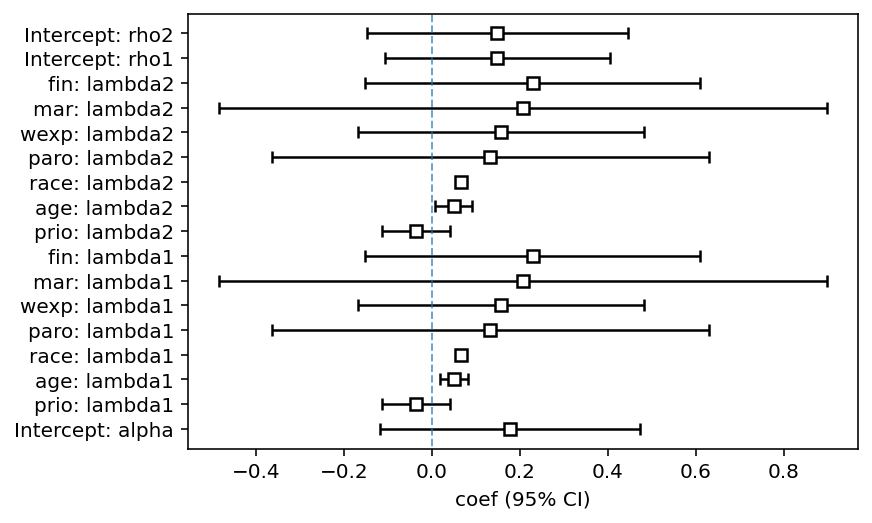

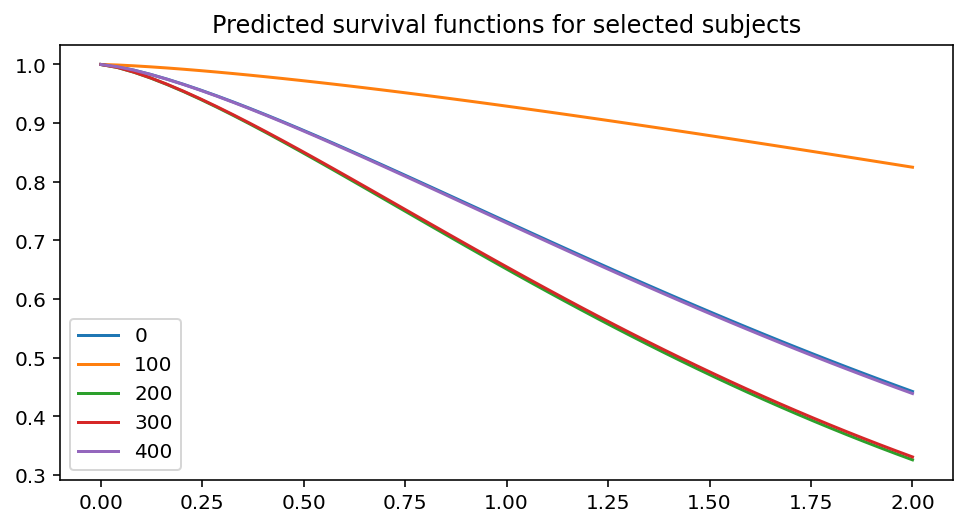

In [2]:
class DependentCompetingRisksHazard(ParametricRegressionFitter):
    """

    Reference
    --------------
    Frees and Valdez, UNDERSTANDING RELATIONSHIPS USING COPULAS
    
    """
    
    _fitted_parameter_names = ["lambda1", "rho1", "lambda2", "rho2", "alpha"]

    def _cumulative_hazard(self, params, T, Xs):
        lambda1 = np.exp(np.dot(Xs["lambda1"], params["lambda1"]))
        lambda2 = np.exp(np.dot(Xs["lambda2"], params["lambda2"]))
        rho2 =    np.exp(np.dot(Xs["rho2"],    params["rho2"]))
        rho1 =    np.exp(np.dot(Xs["rho1"],    params["rho1"]))
        alpha =   np.exp(np.dot(Xs["alpha"],   params["alpha"]))

        return ((T / lambda1) ** rho1 + (T / lambda2) ** rho2) ** alpha


fitter = DependentCompetingRisksHazard(penalizer=0.1)

rossi = load_rossi()
rossi["week"] = rossi["week"] / rossi["week"].max() # scaling often helps with convergence

covariates = {
    "lambda1": rossi.columns.difference(['week', 'arrest']),
    "lambda2": rossi.columns.difference(['week', 'arrest']),
    "rho1": "1",
    "rho2": "1",
    "alpha": "1",
}

fitter.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.linspace(0, 2))
fitter.print_summary(2)

ax = fitter.plot()

ax = fitter.predict_survival_function(rossi.loc[::100]).plot(figsize=(8, 4))
ax.set_title("Predicted survival functions for selected subjects")

### Cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. In this case, the survival function for an individual should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [3]:
from autograd.scipy.special import expit

class CureModel(ParametricRegressionFitter):
    _scipy_fit_method = "SLSQP"
    _scipy_fit_options = {"ftol": 1e-10, "maxiter": 200}

    _fitted_parameter_names = ["lambda_", "beta_", "rho_"]

    def _cumulative_hazard(self, params, T, Xs):
        c = expit(np.dot(Xs["beta_"], params["beta_"]))

        lambda_ = np.exp(np.dot(Xs["lambda_"], params["lambda_"]))
        rho_ = np.exp(np.dot(Xs["rho_"], params["rho_"]))
        sf = np.exp(-(T / lambda_) ** rho_)

        return -np.log((1 - c) + c * sf)


cm = CureModel(penalizer=0.0)

rossi = load_rossi()

covariates = {"lambda_": rossi.columns.difference(['week', 'arrest']), "rho_": "1", "beta_": 'fin + 1'}

cm.fit(rossi, "week", event_col="arrest", regressors=covariates, timeline=np.arange(250)) 
cm.print_summary(2)

<lifelines.CureModel: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
   number of observations = 432
number of events observed = 114
           log-likelihood = -702.64
         time fit was run = 2020-07-26 22:07:13 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                         
lambda_ age         0.16       1.17       0.05             0.05             0.26                 1.06                 1.30
        fin         1.14       3.13    4320.37         -8466.63          8468.92                 0.00                  inf
        mar         0.35       1.42       0.32            -0.27             0.97                 0.76                 2.64
        paro        0.26       1.30       0.24            -0.20             0.72                 0.82                 2.06
        prio       -0.02       0.98       0.04            -0.10             0.06                 0.91                 1.06
        race        0.23       1.26       0.28            -0.32             0.79                 0.72                 2.20
        wexp        0.25       1.28       0.17            -0.08             0.57                 0.92                 1.78
rho_    Intercept   0.13       1.14       0.08            -0.03             0.29                 0.97                 1.34
beta_   Intercept   0.18       1.19       0.10            -0.02             0.37                 0.98                 1.45
        fin        15.80   7.30e+06       0.17            15.46            16.14             5.20e+06             1.03e+07
                      z      p   -log2(p)
param   covariate                        
lambda_ age        2.96 <0.005       8.36
        fin        0.00   1.00       0.00
        mar        1.11   0.27       1.90
        paro       1.10   0.27       1.88
        prio      -0.51   0.61       0.71
        race       0.82   0.41       1.29
        wexp       1.49   0.14       2.86
rho_    Intercept  1.57   0.12       3.11
beta_   Intercept  1.75   0.08       3.64
        fin       90.99 <0.005        inf
---
AIC = 1425.29
log-likelihood ratio test = -12.04 on 7 df
-log2(p) of ll-ratio test = -0.00

<AxesSubplot:>

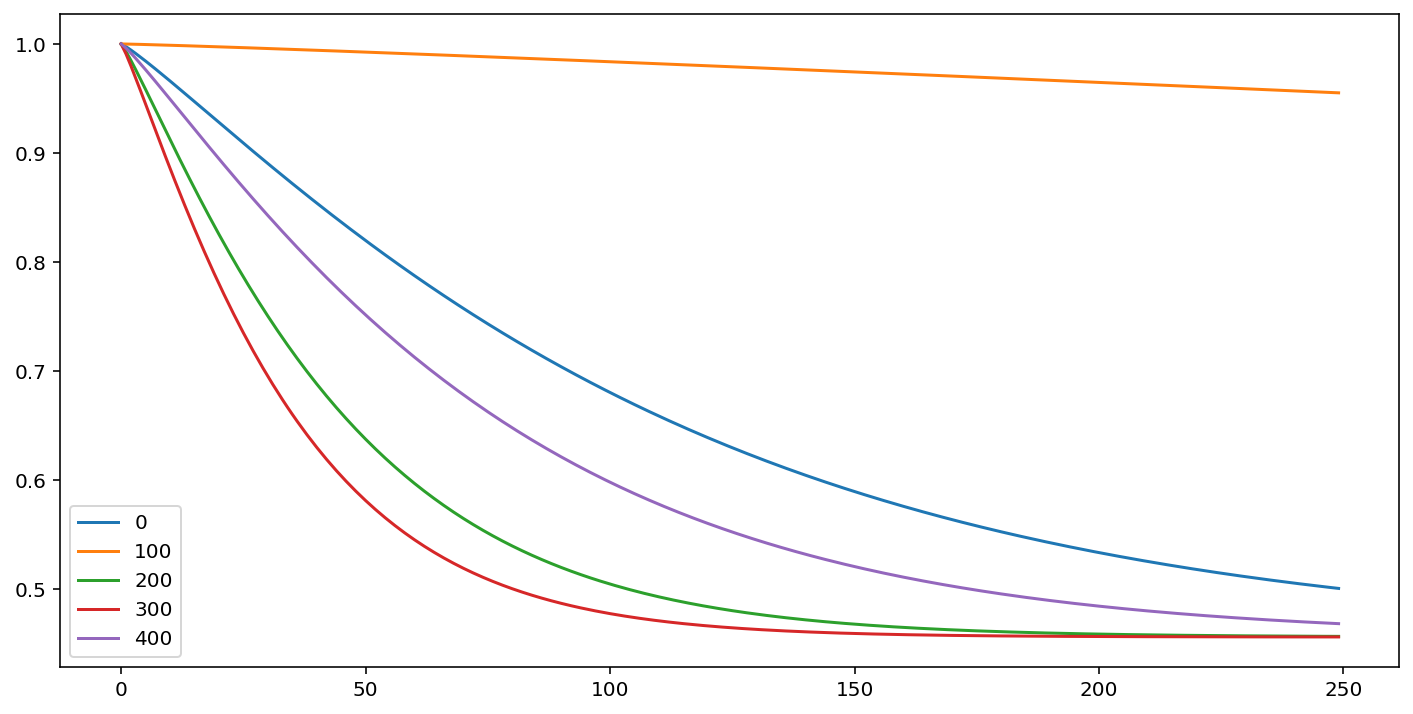

In [4]:
cm.predict_survival_function(rossi.loc[::100]).plot(figsize=(12,6))

<AxesSubplot:>

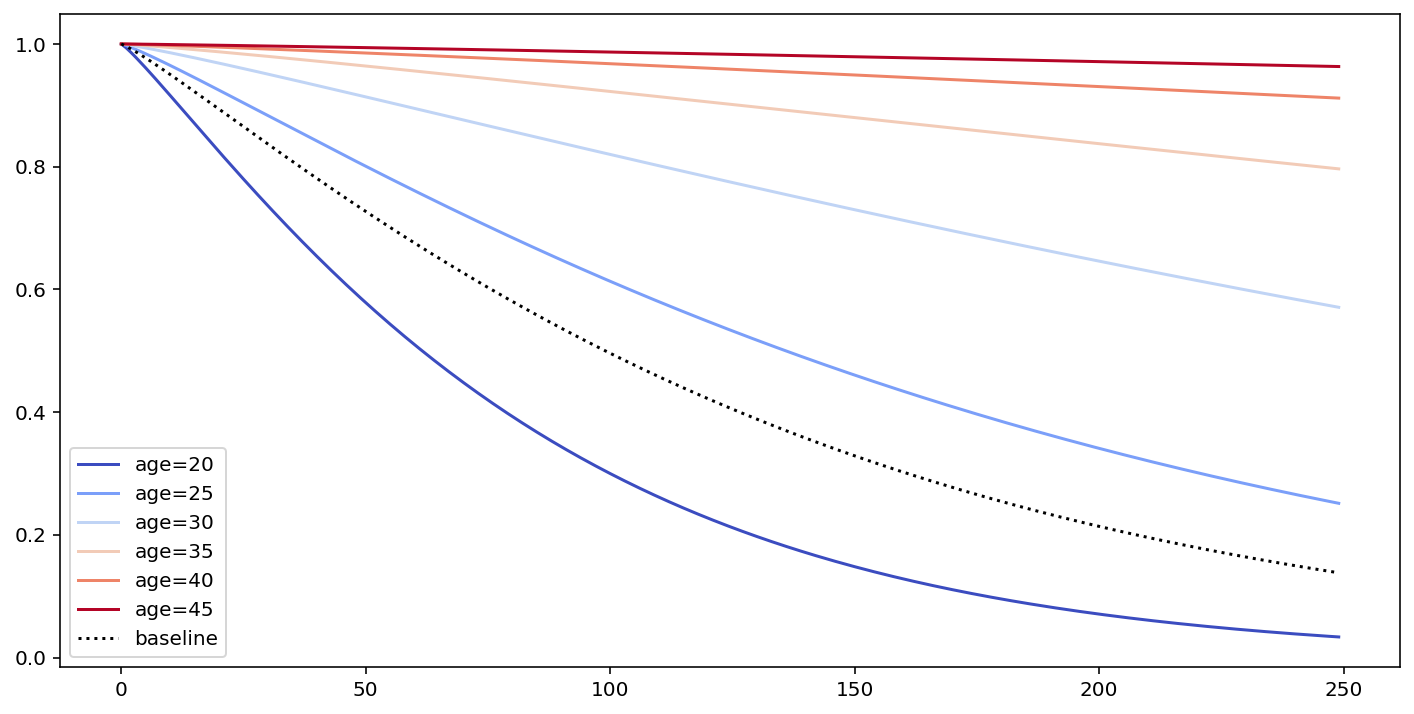

In [5]:
# what's the effect on the survival curve if I vary "age"
fig, ax = plt.subplots(figsize=(12, 6))

cm.plot_covariate_groups(['age'], values=np.arange(20, 50, 5), cmap='coolwarm', ax=ax)

### Spline models

See `royston_parmar_splines.py` in the examples folder: https://github.com/CamDavidsonPilon/lifelines/tree/master/examples